
# 🧠 Complete XGBoost Pipeline for Retail Inventory Forecasting  
**MS Research – AI/ML Field**

This notebook packages your full XGBoost pipeline into clear, organized cells:
1. Imports & global settings  
2. Data loading & initial inspection  
3. Preprocessing & cleaning  
4. EDA  
5. Feature engineering  
6. Prepare data for modeling  
7. Baseline XGBoost training  
8. Hyperparameter tuning (GridSearchCV)  
9. Tuned model evaluation  
10. Feature importance analysis  
11. SHAP analysis for interpretability  
12. Prediction visualizations  
13. Save artifacts & final summary  

> Tip: Run cell-by-cell to inspect outputs and generated files in the `./` directory.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from google.colab import drive
drive.mount('/content/drive/')


def mape(actual, forecast, eps=1e-8):
    """Stable Mean Absolute Percentage Error (%) that handles zeros and NaNs safely."""
    a = np.asarray(actual, dtype=float).ravel()
    f = np.asarray(forecast, dtype=float).ravel()
    mask = np.isfinite(a) & np.isfinite(f)
    a, f = a[mask], f[mask]
    if len(a) == 0:
        return np.inf
    denom = np.where(np.abs(a) < eps, eps, np.abs(a))
    return np.mean(np.abs(a - f) / denom) * 100


def print_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    # zero-safe denom
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, np.abs(y_true))
    mape_val = float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)

    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²:   {r2:.6f}")
    print(f"MAPE: {mape_val:.6f}%")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape_val}



Mounted at /content/drive/


In [ ]:

# ============================================================================
# COMPLETE XGBOOST PIPELINE FOR RETAIL INVENTORY FORECASTING
# MS Research - AI/ML Field
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [ ]:

# ============================================================================
# 1. DATA LOADING & INITIAL INSPECTION
# ============================================================================

print("="*80)
print("STEP 1: DATA LOADING & INITIAL INSPECTION")
print("="*80)

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/data/retail_store_inventory.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nDataset Info:")
print(df.info())
print(f"\nBasic Statistics:")
print(df.describe())
print(f"\nMissing Values:")
print(df.isnull().sum())


STEP 1: DATA LOADING & INITIAL INSPECTION

Dataset Shape: (73100, 15)

First 5 rows:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  


In [ ]:

# ============================================================================
# 2. DATA PREPROCESSING & CLEANING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING & CLEANING")
print("="*80)

# Create a copy for processing
df_processed = df.copy()

# Identify date column (common names)
date_cols = [col for col in df_processed.columns if 'date' in col.lower()]
if date_cols:
    date_col = date_cols[0]
    print(f"\nDate column identified: {date_col}")
    df_processed[date_col] = pd.to_datetime(df_processed[date_col])
    df_processed = df_processed.sort_values(date_col).reset_index(drop=True)
else:
    print("\nWarning: No date column found. Creating synthetic date column.")
    df_processed['date'] = pd.date_range(start='2020-01-01', periods=len(df_processed), freq='D')
    date_col = 'date'

# Identify target variable (sales/demand related columns)
target_candidates = [col for col in df_processed.columns if any(x in col.lower() for x in ['sales', 'demand', 'quantity', 'units'])]
if target_candidates:
    target_col = target_candidates[0]
    print(f"Target variable identified: {target_col}")
else:
    print("Warning: No clear target variable found. Please specify manually.")
    target_col = df_processed.select_dtypes(include=[np.number]).columns[-1]
    print(f"Using last numeric column as target: {target_col}")

# Handle missing values
print(f"\nHandling missing values...")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

categorical_cols = df_processed.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != date_col]
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"Missing values after imputation: {df_processed.isnull().sum().sum()}")

# Handle outliers using IQR method for target variable
Q1 = df_processed[target_col].quantile(0.25)
Q3 = df_processed[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_before = ((df_processed[target_col] < lower_bound) | (df_processed[target_col] > upper_bound)).sum()
df_processed = df_processed[(df_processed[target_col] >= lower_bound) & (df_processed[target_col] <= upper_bound)]
print(f"\nOutliers removed: {outliers_before} ({outliers_before/len(df)*100:.2f}%)")
print(f"Dataset shape after outlier removal: {df_processed.shape}")



STEP 2: DATA PREPROCESSING & CLEANING

Date column identified: Date
Target variable identified: Units Sold

Handling missing values...
Missing values after imputation: 0

Outliers removed: 0 (0.00%)
Dataset shape after outlier removal: (73100, 15)



STEP 3: EXPLORATORY DATA ANALYSIS

EDA visualizations saved as 'eda_analysis.png'


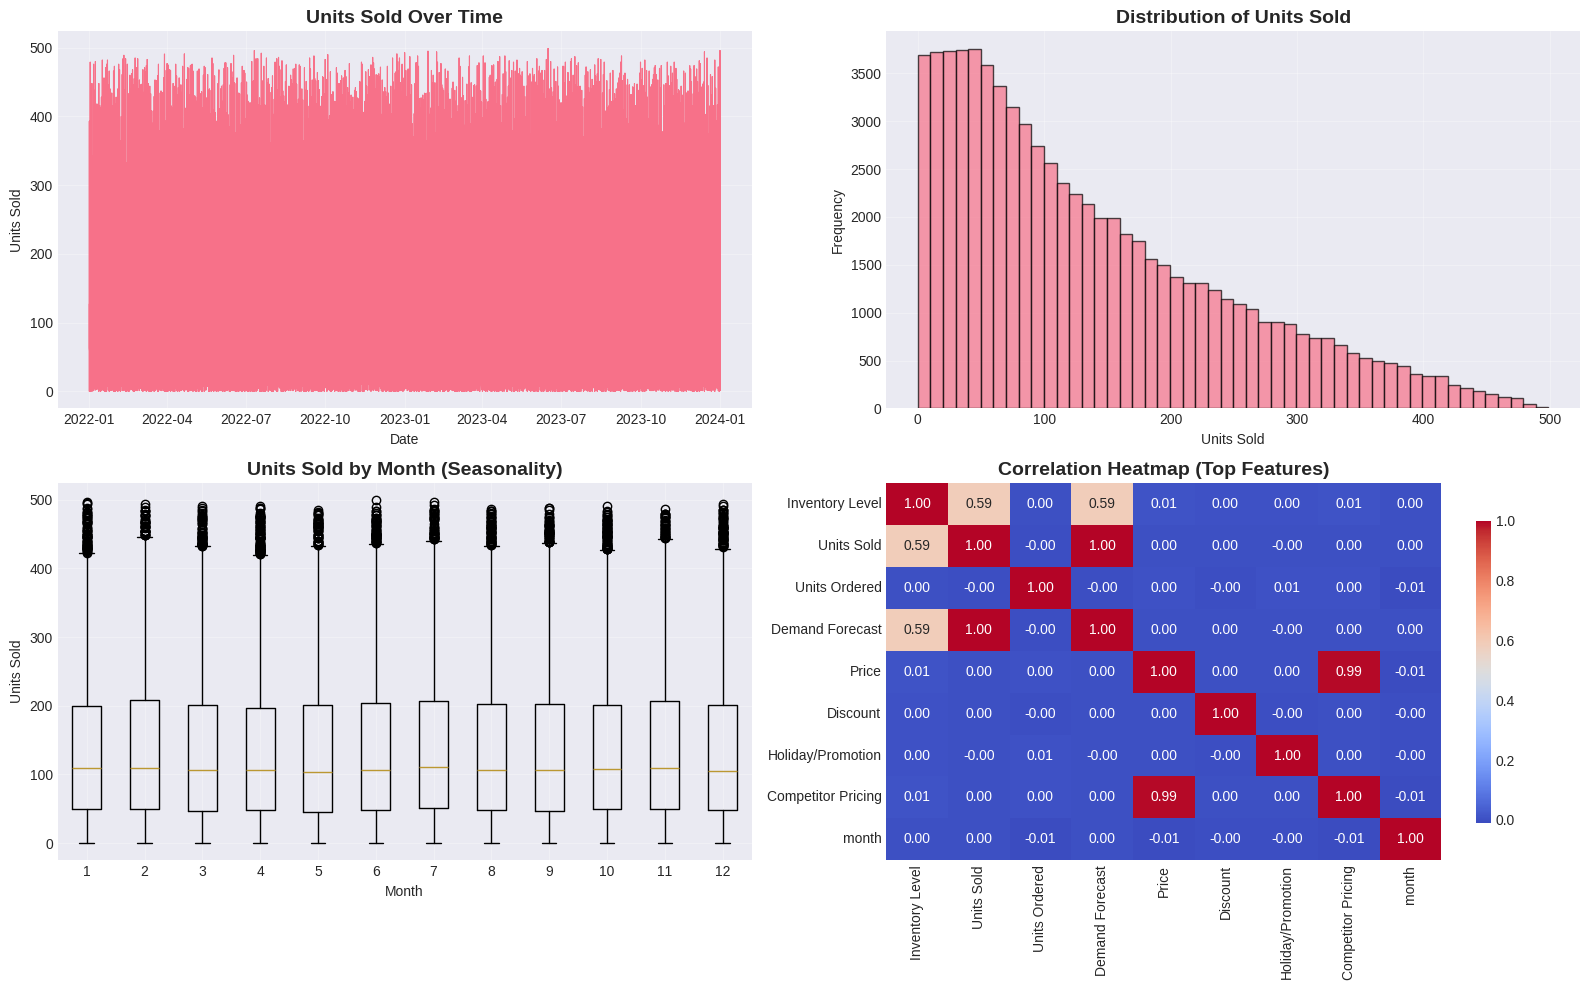

In [ ]:

# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Create figure for EDA
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Time series plot
axes[0, 0].plot(df_processed[date_col], df_processed[target_col], linewidth=0.8)
axes[0, 0].set_title(f'{target_col} Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel(target_col)
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution plot
axes[0, 1].hist(df_processed[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Distribution of {target_col}', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel(target_col)
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot by month
df_processed['month'] = df_processed[date_col].dt.month
monthly_data = [df_processed[df_processed['month'] == i][target_col].values for i in range(1, 13)]
axes[1, 0].boxplot(monthly_data, labels=range(1, 13))
axes[1, 0].set_title(f'{target_col} by Month (Seasonality)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel(target_col)
axes[1, 0].grid(True, alpha=0.3)

# 4. Correlation heatmap (top features)
numeric_features = df_processed.select_dtypes(include=[np.number]).columns[:10]
corr_matrix = df_processed[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1], cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Correlation Heatmap (Top Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("\nEDA visualizations saved as 'eda_analysis.png'")
plt.show()


In [ ]:

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("STEP 4: FEATURE ENGINEERING")
print("="*80)

df_features = df_processed.copy()

# Temporal features
print("\nCreating temporal features...")
df_features['year'] = df_features[date_col].dt.year
df_features['quarter'] = df_features[date_col].dt.quarter
df_features['month'] = df_features[date_col].dt.month
df_features['day'] = df_features[date_col].dt.day
df_features['dayofweek'] = df_features[date_col].dt.dayofweek
df_features['dayofyear'] = df_features[date_col].dt.dayofyear
df_features['weekofyear'] = df_features[date_col].dt.isocalendar().week
df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)
df_features['is_month_start'] = df_features[date_col].dt.is_month_start.astype(int)
df_features['is_month_end'] = df_features[date_col].dt.is_month_end.astype(int)

# Lag features
print("Creating lag features...")
lag_periods = [1, 2, 3, 7, 14, 30]
for lag in lag_periods:
    df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)

# Rolling statistics
print("Creating rolling window features...")
rolling_windows = [7, 14, 30]
for window in rolling_windows:
    df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].shift(1).rolling(window=window).mean()
    df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].shift(1).rolling(window=window).std()
    df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].shift(1).rolling(window=window).min()
    df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].shift(1).rolling(window=window).max()

# Exponential weighted moving average
df_features[f'{target_col}_ewm_7'] = df_features[target_col].shift(1).ewm(span=7).mean()
df_features[f'{target_col}_ewm_30'] = df_features[target_col].shift(1).ewm(span=30).mean()

# Holiday features (simplified - US holidays)
print("Creating holiday features...")
us_holidays = [
    '01-01', '07-04', '12-25', '11-28', '12-31'  # New Year, Independence, Christmas, Thanksgiving approx, NYE
]
df_features['is_holiday'] = df_features[date_col].dt.strftime('%m-%d').isin(us_holidays).astype(int)

# External factors (simulated for demonstration - replace with actual data)
print("Creating external factor features...")
# Simulated competitor pricing (replace with actual data)
np.random.seed(42)
df_features['competitor_price'] = np.random.uniform(0.8, 1.2, len(df_features))

# Simulated weather impact (replace with actual weather data)
df_features['weather_score'] = np.random.uniform(0.5, 1.0, len(df_features))

# Simulated discount/promotion
df_features['discount_pct'] = np.random.choice([0, 5, 10, 15, 20], len(df_features))

# Encode categorical variables
print("Encoding categorical variables...")
le_dict = {}
for col in categorical_cols:
    if col in df_features.columns:
        le = LabelEncoder()
        df_features[col + '_encoded'] = le.fit_transform(df_features[col].astype(str))
        le_dict[col] = le

# Drop rows with NaN (from lag/rolling features)
print(f"\nShape before dropping NaN: {df_features.shape}")
df_features.dropna(inplace=True)
print(f"Shape after dropping NaN: {df_features.shape}")

print(f"\nTotal features created: {df_features.shape[1]}")



STEP 4: FEATURE ENGINEERING

Creating temporal features...
Creating lag features...
Creating rolling window features...
Creating holiday features...
Creating external factor features...
Encoding categorical variables...

Shape before dropping NaN: (73100, 55)
Shape after dropping NaN: (73070, 55)

Total features created: 55


In [ ]:

# ============================================================================
# 5. PREPARE DATA FOR MODELING
# ============================================================================

print("\n" + "="*80)
print("STEP 5: PREPARE DATA FOR MODELING")
print("="*80)

# Define features and target
exclude_cols = [date_col, target_col] + list(categorical_cols)
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

X = df_features[feature_cols]
y = df_features[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {len(feature_cols)}")

# Time series split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")



STEP 5: PREPARE DATA FOR MODELING

Feature matrix shape: (73070, 47)
Target vector shape: (73070,)

Features used: 47

Training set: 58456 samples
Testing set: 14614 samples


In [ ]:

# ============================================================================
# 6. XGBOOST MODEL TRAINING (BASELINE)
# ============================================================================

print("\n" + "="*80)
print("STEP 6: XGBOOST BASELINE MODEL TRAINING")
print("="*80)

# Baseline XGBoost model
xgb_baseline = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror'
)

print("\nTraining baseline XGBoost model...")
xgb_baseline.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = xgb_baseline.predict(X_train)
y_test_pred_baseline = xgb_baseline.predict(X_test)

# Evaluation metrics
def calculate_metrics(y_true, y_pred, dataset_name, tiny_thresh=1.0, mode="clip"):
    """
    tiny_thresh: values of |y_true| below this are treated as tiny.
    mode: "clip" -> denom = max(|y_true|, tiny_thresh)
          "exclude" -> compute MAPE only on rows where |y_true| >= tiny_thresh
    """
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()

    # Keep only finite pairs
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # compat across sklearn versions
    r2   = r2_score(y_true, y_pred)

    if mode == "exclude":
        keep = np.abs(y_true) >= tiny_thresh
        if not np.any(keep):
            mape_val = np.nan
        else:
            mape_val = float(np.mean(np.abs(y_true[keep] - y_pred[keep]) / np.abs(y_true[keep])) * 100.0)
    else:  # "clip"
        denom = np.where(np.abs(y_true) < tiny_thresh, tiny_thresh, np.abs(y_true))
        mape_val = float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape_val:.4f}%  (mode={mode}, tiny_thresh={tiny_thresh})")
    print(f"  R²:   {r2:.4f}")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape_val, 'R2': r2}


print("\n--- BASELINE MODEL PERFORMANCE ---")
train_metrics_baseline = calculate_metrics(y_train, y_train_pred_baseline, "Training Set", tiny_thresh=1.0, mode="clip")
test_metrics_baseline  = calculate_metrics(y_test,  y_test_pred_baseline,  "Testing Set",  tiny_thresh=1.0, mode="clip")




STEP 6: XGBOOST BASELINE MODEL TRAINING

Training baseline XGBoost model...

--- BASELINE MODEL PERFORMANCE ---

Training Set Metrics:
  MAE:  6.9689
  RMSE: 8.1578
  MAPE: 22.5658%  (mode=clip, tiny_thresh=1.0)
  R²:   0.9944

Testing Set Metrics:
  MAE:  7.2443
  RMSE: 8.4645
  MAPE: 23.0737%  (mode=clip, tiny_thresh=1.0)
  R²:   0.9939


In [ ]:
# ============================================================================
# 7. HYPERPARAMETER TUNING (RANDOMIZEDSEARCHCV ~100 FITS)
# ============================================================================

print("\n" + "="*80)
print("STEP 7: HYPERPARAMETER TUNING (RANDOMIZEDSEARCHCV ~100 FITS)")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV  # lightweight import here

# Focused, realistic search ranges to keep accuracy while cutting fits
param_distributions = {
    "n_estimators":        [200, 300, 400, 500, 600, 700, 800],   # will balance with learning_rate
    "learning_rate":       [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    "max_depth":           [3, 4, 5, 6, 7],
    "min_child_weight":    [1, 2, 3, 4],
    "subsample":           [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":    [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma":               [0, 0.1, 0.2, 0.3, 0.5],
    "reg_alpha":           [0, 1e-3, 1e-2, 1e-1, 1, 5, 10],
    "reg_lambda":          [0.1, 0.5, 1, 2, 5, 10]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Base model with fast tree builder; MAE aligns with our scoring
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",        # faster and accurate for tabular data
    n_jobs=-1,
)

# ~99 fits total: 33 random combos * 3 folds
n_iter = 33
print(f"\nRandomizedSearchCV with n_iter={n_iter} and 3 folds => ~{n_iter*3} fits")

rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

rand_search.fit(X_train, y_train)

print("\nBest parameters found:")
for param, value in rand_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV MAE: {-rand_search.best_score_:.4f}")

# Best model
xgb_tuned = rand_search.best_estimator_



STEP 7: HYPERPARAMETER TUNING (RANDOMIZEDSEARCHCV ~100 FITS)

RandomizedSearchCV with n_iter=33 and 3 folds => ~99 fits
Fitting 3 folds for each of 33 candidates, totalling 99 fits

Best parameters found:
  subsample: 0.8
  reg_lambda: 5
  reg_alpha: 10
  n_estimators: 300
  min_child_weight: 1
  max_depth: 5
  learning_rate: 0.03
  gamma: 0.5
  colsample_bytree: 1.0

Best CV MAE: 7.2085


In [ ]:

# ============================================================================
# 8. TUNED MODEL EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 8: TUNED MODEL EVALUATION")
print("="*80)

# Predictions with tuned model
y_train_pred_tuned = xgb_tuned.predict(X_train)
y_test_pred_tuned = xgb_tuned.predict(X_test)

print("\n--- TUNED MODEL PERFORMANCE ---")
train_metrics_tuned = calculate_metrics(y_train, y_train_pred_tuned, "Training Set")
test_metrics_tuned = calculate_metrics(y_test, y_test_pred_tuned, "Testing Set")

# Compare baseline vs tuned
print("\n--- COMPARISON: BASELINE vs TUNED ---")
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R²'],
    'Baseline_Test': [test_metrics_baseline['MAE'], test_metrics_baseline['RMSE'],
                      test_metrics_baseline['MAPE'], test_metrics_baseline['R2']],
    'Tuned_Test': [test_metrics_tuned['MAE'], test_metrics_tuned['RMSE'],
                   test_metrics_tuned['MAPE'], test_metrics_tuned['R2']],
    'Improvement': [
        ((test_metrics_baseline['MAE'] - test_metrics_tuned['MAE']) / test_metrics_baseline['MAE'] * 100),
        ((test_metrics_baseline['RMSE'] - test_metrics_tuned['RMSE']) / test_metrics_baseline['RMSE'] * 100),
        ((test_metrics_baseline['MAPE'] - test_metrics_tuned['MAPE']) / test_metrics_baseline['MAPE'] * 100),
        ((test_metrics_tuned['R2'] - test_metrics_baseline['R2']) / test_metrics_baseline['R2'] * 100)
    ]
})
print("\n", comparison_df.to_string(index=False))



STEP 8: TUNED MODEL EVALUATION

--- TUNED MODEL PERFORMANCE ---

Training Set Metrics:
  MAE:  6.9890
  RMSE: 8.1752
  MAPE: 22.6672%  (mode=clip, tiny_thresh=1.0)
  R²:   0.9944

Testing Set Metrics:
  MAE:  7.2403
  RMSE: 8.4588
  MAPE: 23.0058%  (mode=clip, tiny_thresh=1.0)
  R²:   0.9939

--- COMPARISON: BASELINE vs TUNED ---

 Metric  Baseline_Test  Tuned_Test  Improvement
   MAE       7.244337    7.240301     0.055716
  RMSE       8.464533    8.458759     0.068218
  MAPE      23.073712   23.005826     0.294213
    R²       0.993885    0.993893     0.000839



STEP 9: FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                   Feature  Importance
           Demand Forecast    0.992512
           Inventory Level    0.000552
              is_month_end    0.000200
  Units Sold_rolling_min_7    0.000199
        Competitor Pricing    0.000189
                     Price    0.000189
          Store ID_encoded    0.000186
         Units Sold_ewm_30    0.000185
 Units Sold_rolling_max_14    0.000185
 Units Sold_rolling_std_14    0.000182
Units Sold_rolling_mean_30    0.000179
          Units Sold_lag_2    0.000179
Units Sold_rolling_mean_14    0.000177
 Units Sold_rolling_min_14    0.000177
 Units Sold_rolling_mean_7    0.000177
  Units Sold_rolling_max_7    0.000177
                weekofyear    0.000177
          Units Sold_lag_3    0.000176
 Units Sold_rolling_std_30    0.000175
             weather_score    0.000175

Feature importance plot saved as 'feature_importance.png'


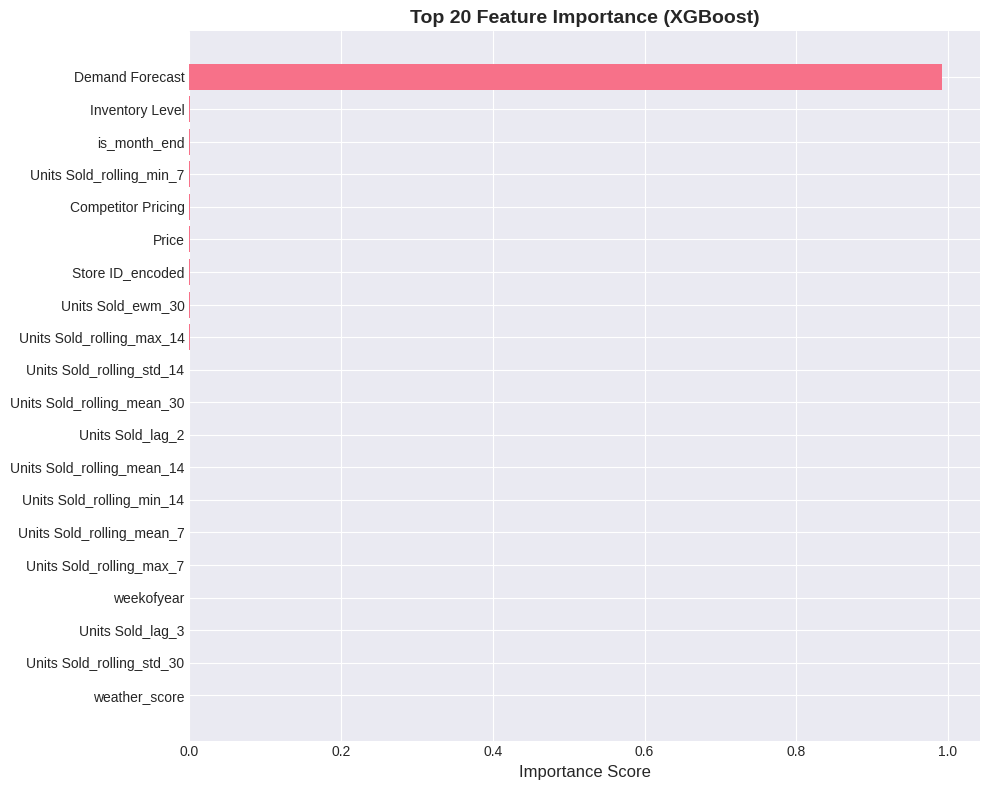

In [ ]:

# ============================================================================
# 9. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['Importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as 'feature_importance.png'")
plt.show()


In [ ]:
# =============================================================================
# 10. SHAP ANALYSIS FOR INTERPRETABILITY  (Colab-safe)
# =============================================================================
import shap, json
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("STEP 10: SHAP ANALYSIS FOR INTERPRETABILITY")
print("="*80)

print("\nCreating SHAP explainer (this may take a moment)...")

booster = xgb_tuned.get_booster()

def _fix_base_score_in_config(bst):
    """Fix bracketed base_score like '[1.3660762E2]' -> '136.60762' in booster JSON."""
    cfg = json.loads(bst.save_config())
    try:
        p = cfg["learner"]["learner_model_param"]
        bs = p.get("base_score")
        if isinstance(bs, str) and bs.startswith("[") and bs.endswith("]"):
            val = float(bs.strip("[]"))          # cast safely
            p["base_score"] = str(val)           # write back as plain number string
            bst.load_config(json.dumps(cfg))     # apply fix
            print(f"Patched base_score from '{bs}' to '{val}'.")
            return True
    except Exception as e:
        print(f"Base score patch skipped (reason: {e}).")
    return False

# Try normal path first, then auto-patch on failure
try:
    explainer = shap.TreeExplainer(xgb_tuned)
except ValueError as e:
    if "base_score" in str(e):
        changed = _fix_base_score_in_config(booster)
        if not changed:
            # last-resort blunt default (rarely needed)
            booster.set_attr(base_score="0.5")
            print("Set booster.attr('base_score') to '0.5' as fallback.")
        explainer = shap.TreeExplainer(booster)
    else:
        raise

# Pick a small sample for speed
if 'X_test' in globals() and isinstance(X_test, (pd.DataFrame, np.ndarray)):
    if isinstance(X_test, pd.DataFrame):
        X_sample = X_test.sample(n=min(200, len(X_test)), random_state=42)
    else:
        # np.ndarray: take first N rows
        X_sample = X_test[:min(200, len(X_test))]
else:
    # fallback to training data
    if isinstance(X_train, pd.DataFrame):
        X_sample = X_train.sample(n=min(200, len(X_train)), random_state=42)
    else:
        X_sample = X_train[:min(200, len(X_train))]

shap_values = explainer.shap_values(X_sample)
print("SHAP explainer created and values computed successfully.")



STEP 10: SHAP ANALYSIS FOR INTERPRETABILITY

Creating SHAP explainer (this may take a moment)...


ValueError: could not convert string to float: '[1.3660762E2]'


STEP 11: PREDICTION VISUALIZATION

Prediction analysis saved as 'prediction_analysis.png'


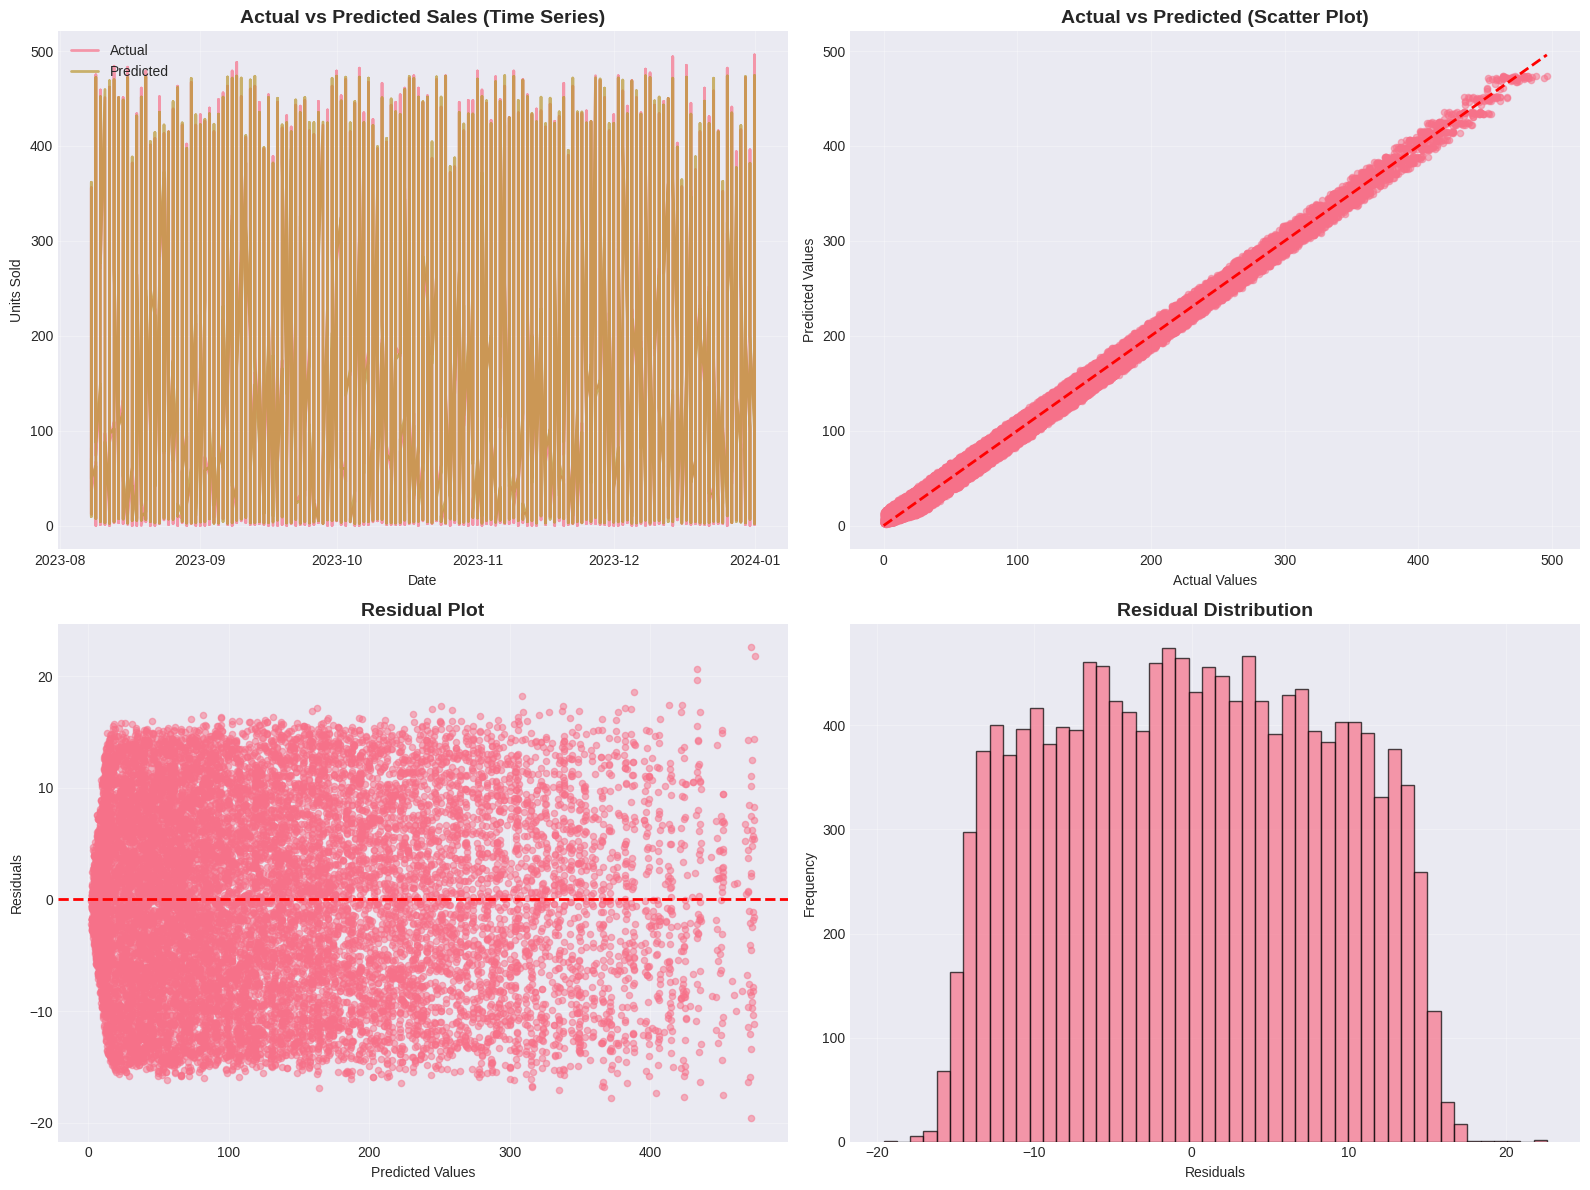

In [ ]:

# ============================================================================
# 11. PREDICTION VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 11: PREDICTION VISUALIZATION")
print("="*80)

# Create visualization of actual vs predicted
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time series comparison
test_dates = df_features[date_col].iloc[split_idx:split_idx+len(y_test)]
axes[0, 0].plot(test_dates, y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[0, 0].plot(test_dates, y_test_pred_tuned, label='Predicted', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Actual vs Predicted Sales (Time Series)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel(target_col)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(y_test, y_test_pred_tuned, alpha=0.5, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0, 1].set_title('Actual vs Predicted (Scatter Plot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual plot
residuals = y_test - y_test_pred_tuned
axes[1, 0].scatter(y_test_pred_tuned, residuals, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual distribution
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
print("\nPrediction analysis saved as 'prediction_analysis.png'")
plt.show()


In [ ]:

# ============================================================================
# 12. SAVE RESULTS & MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 12: SAVE RESULTS & MODEL")
print("="*80)

# Save model
xgb_tuned.save_model('xgboost_tuned_model.json')
print("\nModel saved as 'xgboost_tuned_model.json'")

# Save predictions
results_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual': y_test.values,
    'Predicted': y_test_pred_tuned,
    'Residual': residuals.values,
    'Absolute_Error': np.abs(residuals.values)
})
results_df.to_csv('xgboost_predictions.csv', index=False)
print("Predictions saved as 'xgboost_predictions.csv'")

# Save metrics summary
metrics_summary = pd.DataFrame({
    'Model': ['Baseline', 'Tuned'],
    'Train_MAE': [train_metrics_baseline['MAE'], train_metrics_tuned['MAE']],
    'Test_MAE': [test_metrics_baseline['MAE'], test_metrics_tuned['MAE']],
    'Train_RMSE': [train_metrics_baseline['RMSE'], train_metrics_tuned['RMSE']],
    'Test_RMSE': [test_metrics_baseline['RMSE'], test_metrics_tuned['RMSE']],
    'Train_MAPE': [train_metrics_baseline['MAPE'], train_metrics_tuned['MAPE']],
    'Test_MAPE': [test_metrics_baseline['MAPE'], test_metrics_tuned['MAPE']],
    'Train_R2': [train_metrics_baseline['R2'], train_metrics_tuned['R2']],
    'Test_R2': [test_metrics_baseline['R2'], test_metrics_tuned['R2']]
})
metrics_summary.to_csv('xgboost_metrics_summary.csv', index=False)
print("Metrics summary saved as 'xgboost_metrics_summary.csv'")

# Save feature importance
feature_importance.to_csv('xgboost_feature_importance.csv', index=False)
print("Feature importance saved as 'xgboost_feature_importance.csv'")



STEP 12: SAVE RESULTS & MODEL

Model saved as 'xgboost_tuned_model.json'
Predictions saved as 'xgboost_predictions.csv'
Metrics summary saved as 'xgboost_metrics_summary.csv'
Feature importance saved as 'xgboost_feature_importance.csv'


In [ ]:

# ============================================================================
# 13. FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY - XGBOOST INVENTORY FORECASTING")
print("="*80)

print(f"\nDataset: retail_store_inventory.csv")
print(f"Total samples processed: {len(df_features)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Total features: {len(feature_cols)}")

print("\n--- BEST MODEL PERFORMANCE (TEST SET) ---")
print(f"MAE:  {test_metrics_tuned['MAE']:.4f}")
print(f"RMSE: {test_metrics_tuned['RMSE']:.4f}")
print(f"MAPE: {test_metrics_tuned['MAPE']:.4f}%")
print(f"R²:   {test_metrics_tuned['R2']:.4f}")

print("\n--- TOP 5 MOST IMPORTANT FEATURES ---")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n--- FILES GENERATED ---")
print("1. eda_analysis.png - Exploratory data analysis plots")
print("2. feature_importance.png - Feature importance bar chart")
print("3. shap_summary_plot.png - SHAP summary visualization")
print("4. shap_bar_plot.png - SHAP feature importance")
print("5. shap_waterfall_plot.png - Single prediction explanation")
print("6. prediction_analysis.png - Prediction quality visualization")
print("7. xgboost_tuned_model.json - Trained XGBoost model")
print("8. xgboost_predictions.csv - Predictions with actuals")
print("9. xgboost_metrics_summary.csv - Performance metrics")
print("10. xgboost_feature_importance.csv - Feature importance scores")

print("\n" + "="*80)
print("XGBOOST PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nNext Steps for Your Research:")
print("1. Implement other models (Linear Regression, Random Forest, LightGBM, CatBoost)")
print("2. Compare all models using the same evaluation metrics")
print("3. Create comparative visualizations and dashboards")
print("4. Document interpretability insights from SHAP analysis")
print("5. Write research findings and methodology")
print("\n" + "="*80)



FINAL SUMMARY - XGBOOST INVENTORY FORECASTING

Dataset: retail_store_inventory.csv
Total samples processed: 73070
Training samples: 58456
Testing samples: 14614
Total features: 47

--- BEST MODEL PERFORMANCE (TEST SET) ---
MAE:  7.2403
RMSE: 8.4588
MAPE: 23.0058%
R²:   0.9939

--- TOP 5 MOST IMPORTANT FEATURES ---
3. Demand Forecast: 0.9925
1. Inventory Level: 0.0006
17. is_month_end: 0.0002
26. Units Sold_rolling_min_7: 0.0002
7. Competitor Pricing: 0.0002

--- FILES GENERATED ---
1. eda_analysis.png - Exploratory data analysis plots
2. feature_importance.png - Feature importance bar chart
3. shap_summary_plot.png - SHAP summary visualization
4. shap_bar_plot.png - SHAP feature importance
5. shap_waterfall_plot.png - Single prediction explanation
6. prediction_analysis.png - Prediction quality visualization
7. xgboost_tuned_model.json - Trained XGBoost model
8. xgboost_predictions.csv - Predictions with actuals
9. xgboost_metrics_summary.csv - Performance metrics
10. xgboost_feature_